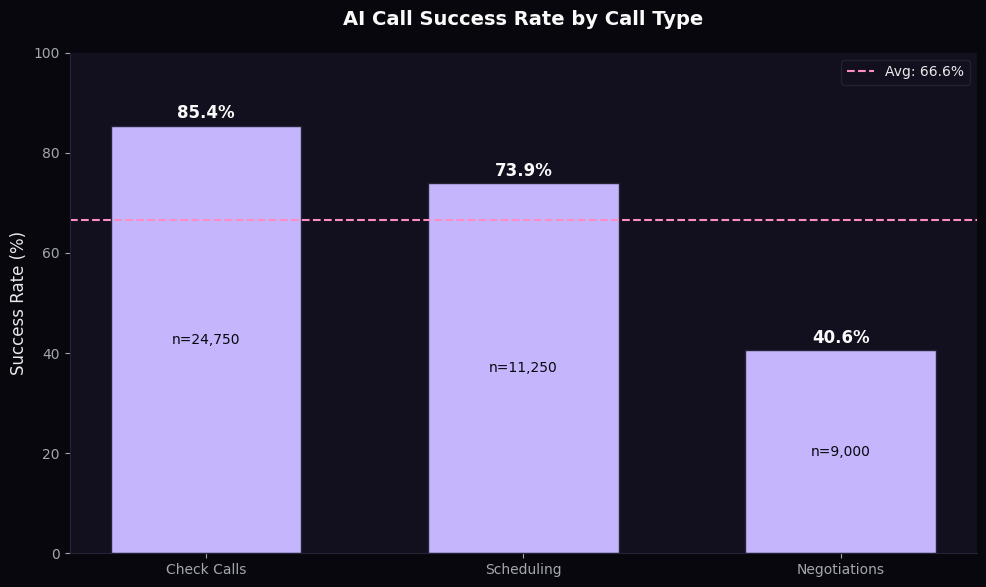


Call Type        Total Calls   Successful Success Rate
-------------------------------------------------------
Check Calls           24,750       21,146        85.4%
Scheduling            11,250        8,316        73.9%
Negotiations           9,000        3,650        40.6%


In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import os

# SignalPilot dark theme style setup
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.facecolor': '#08070e',
    'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336',
    'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA',
    'xtick.color': '#a4a7ae',
    'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b',
    'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336',
    'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})

COLORS = {
    'primary': '#c4b5fd',
    'secondary': '#ff8dc4',
    'tertiary': '#8b5cf6',
    'green': '#4ca86f',
    'red': '#c45757',
}

# Connect to HappyRobot database
engine = create_engine(os.environ['HAPPYROBOT_CONNECTION_URL'])

# Query: Success rate by call type
query = """
SELECT 
    call_type,
    COUNT(*) as total_calls,
    SUM(CASE WHEN outcome IN ('status_confirmed', 'deal_closed', 'appointment_booked', 'rescheduled') THEN 1 ELSE 0 END) as successful_calls,
    ROUND(100.0 * SUM(CASE WHEN outcome IN ('status_confirmed', 'deal_closed', 'appointment_booked', 'rescheduled') THEN 1 ELSE 0 END) / COUNT(*), 1) as success_rate
FROM call_log
GROUP BY call_type
ORDER BY success_rate DESC
"""

df = pd.read_sql(query, engine)
engine.dispose()

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

call_type_labels = {'check_call': 'Check Calls', 'scheduling': 'Scheduling', 'negotiation': 'Negotiations'}
df['call_type_label'] = df['call_type'].map(call_type_labels)

bars = ax.bar(df['call_type_label'], df['success_rate'], color=COLORS['primary'], width=0.6, edgecolor='#272336')

# Add value labels on bars
for bar, rate, total in zip(bars, df['success_rate'], df['total_calls']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5,
            f'{rate:.1f}%', ha='center', fontsize=12, fontweight='bold', color='#FAFAFA')
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
            f'n={total:,}', ha='center', va='center', fontsize=10, color='#08070e')

ax.set_ylabel('Success Rate (%)')
ax.set_title('AI Call Success Rate by Call Type', fontweight='bold', pad=20)
ax.set_ylim(0, 100)
ax.axhline(y=df['success_rate'].mean(), color=COLORS['secondary'], linestyle='--', linewidth=1.5, label=f"Avg: {df['success_rate'].mean():.1f}%")
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Display summary table
print(f"\n{'Call Type':<15} {'Total Calls':>12} {'Successful':>12} {'Success Rate':>12}")
print("-" * 55)
for _, row in df.iterrows():
    print(f"{call_type_labels[row['call_type']]:<15} {row['total_calls']:>12,} {row['successful_calls']:>12,} {row['success_rate']:>11.1f}%")

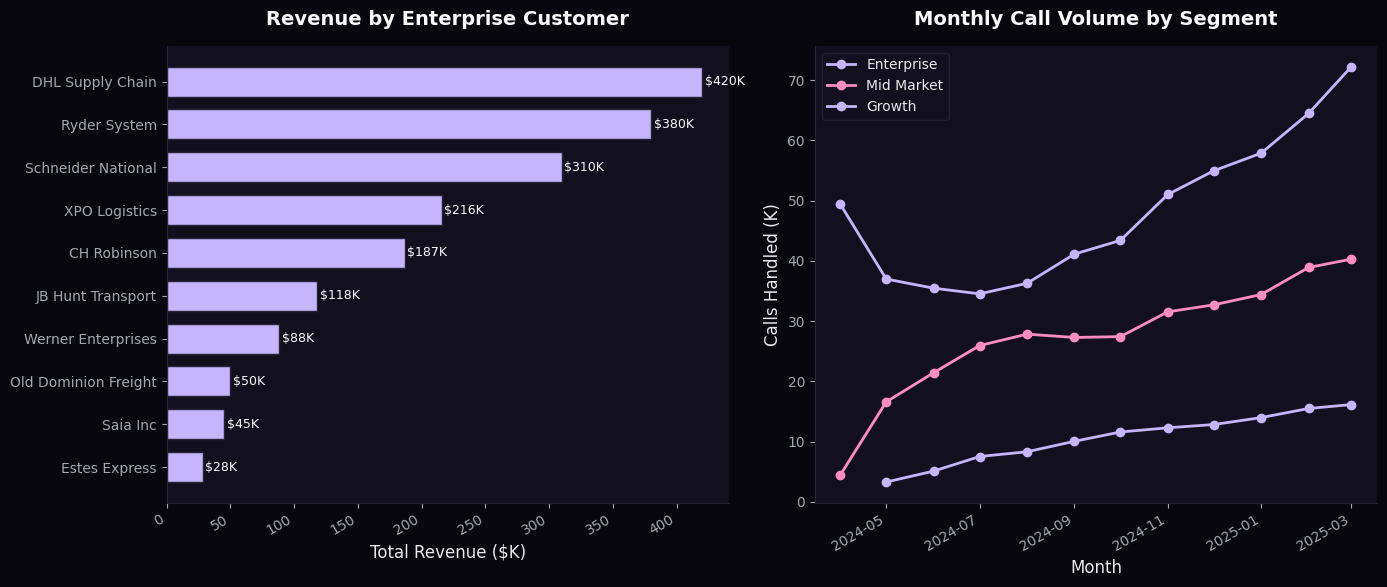


Month-over-Month Call Volume Growth (%):
segment     enterprise  growth  mid_market
month                                     
2024-10-01         5.5    15.3         0.5
2024-11-01        17.6     6.0        15.0
2024-12-01         7.7     4.4         3.7
2025-01-01         5.3     8.9         5.2
2025-02-01        11.4    10.8        13.0
2025-03-01        12.1     4.2         3.6


In [2]:
# Revenue per enterprise customer & usage trends
query_enterprise = """
SELECT 
    c.company_name,
    c.acv_usd,
    SUM(m.revenue_usd) as total_revenue,
    SUM(m.calls_handled) as total_calls,
    COUNT(DISTINCT m.month) as months_active
FROM customers c
JOIN monthly_usage m ON c.id = m.customer_id
WHERE c.segment = 'enterprise'
GROUP BY c.id, c.company_name, c.acv_usd
ORDER BY total_revenue DESC
"""

query_monthly = """
SELECT 
    m.month,
    c.segment,
    SUM(m.calls_handled) as total_calls,
    SUM(m.revenue_usd) as total_revenue,
    COUNT(DISTINCT m.customer_id) as active_customers
FROM monthly_usage m
JOIN customers c ON c.id = m.customer_id
GROUP BY m.month, c.segment
ORDER BY m.month, c.segment
"""

engine = create_engine(os.environ['HAPPYROBOT_CONNECTION_URL'])
df_enterprise = pd.read_sql(query_enterprise, engine)
df_monthly = pd.read_sql(query_monthly, engine)
engine.dispose()

df_monthly['month'] = pd.to_datetime(df_monthly['month'])

# Create 2-panel figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Revenue per Enterprise Customer (horizontal bar)
ax1 = axes[0]
bars = ax1.barh(df_enterprise['company_name'], df_enterprise['total_revenue']/1000, 
                color=COLORS['primary'], height=0.7, edgecolor='#272336')
ax1.set_xlabel('Total Revenue ($K)')
ax1.set_title('Revenue by Enterprise Customer', fontweight='bold', pad=15)
ax1.invert_yaxis()
for bar, rev in zip(bars, df_enterprise['total_revenue']):
    ax1.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
             f'${rev/1000:.0f}K', va='center', fontsize=9, color='#FAFAFA')

# Panel 2: Monthly Usage Trend by Segment
ax2 = axes[1]
segment_colors = {'enterprise': COLORS['primary'], 'mid_market': COLORS['secondary'], 'smb': COLORS['tertiary']}

for segment in df_monthly['segment'].unique():
    seg_data = df_monthly[df_monthly['segment'] == segment]
    ax2.plot(seg_data['month'], seg_data['total_calls']/1000, 
             marker='o', linewidth=2, markersize=6,
             color=segment_colors.get(segment, COLORS['primary']), 
             label=segment.replace('_', ' ').title())

ax2.set_xlabel('Month')
ax2.set_ylabel('Calls Handled (K)')
ax2.set_title('Monthly Call Volume by Segment', fontweight='bold', pad=15)
ax2.legend(loc='upper left')
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

# MoM growth calculation
pivot = df_monthly.pivot(index='month', columns='segment', values='total_calls').fillna(0)
mom_growth = pivot.pct_change() * 100

print("\nMonth-over-Month Call Volume Growth (%):")
print(mom_growth.round(1).tail(6).to_string())

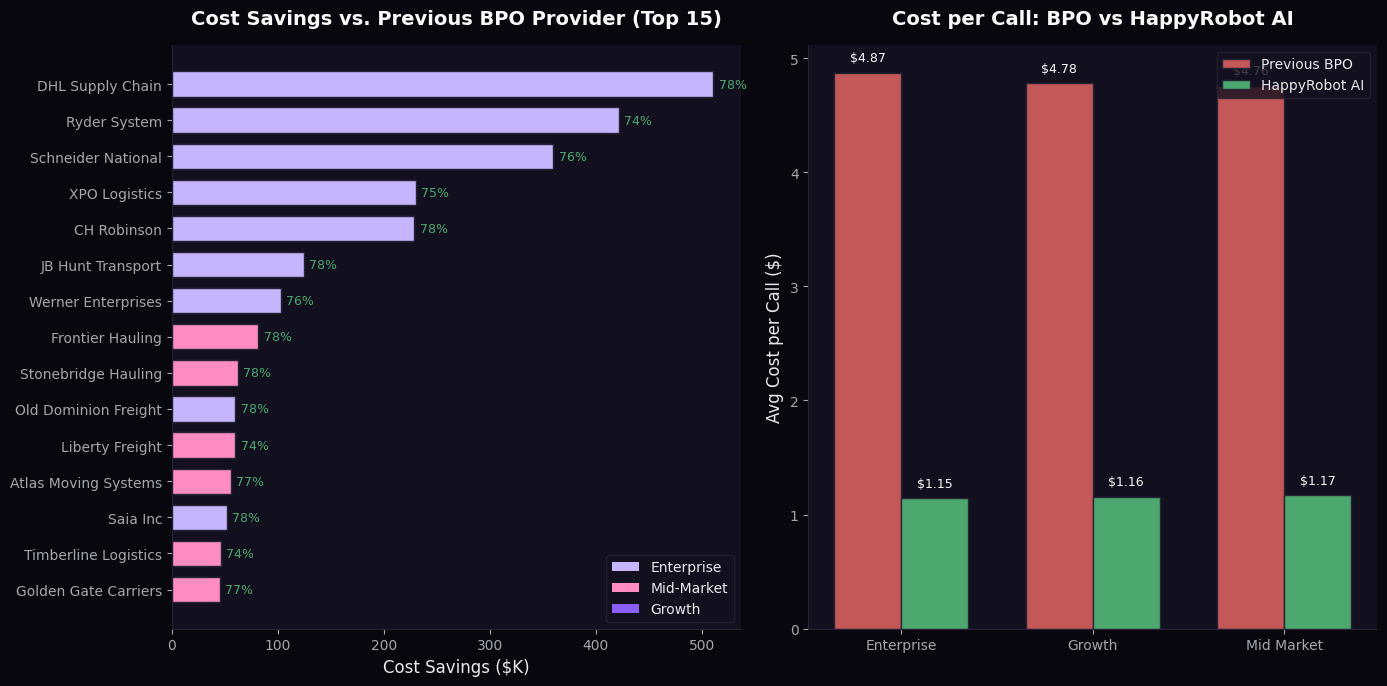


TOTAL COST SAVINGS ACROSS ALL CUSTOMERS: $3,396,763
AVERAGE SAVINGS: 75.7% reduction vs. previous BPO


In [6]:
# Cost savings analysis: HappyRobot AI vs previous BPO providers
from sqlalchemy import text

query_savings = """
WITH customer_costs AS (
    SELECT 
        m.customer_id,
        SUM(m.calls_handled) as total_calls,
        SUM(m.calls_handled * m.cost_per_call_usd) as happyrobot_total_cost,
        AVG(m.cost_per_call_usd) as happyrobot_cost_per_call
    FROM monthly_usage m
    GROUP BY m.customer_id
)
SELECT 
    c.company_name,
    c.segment,
    b.previous_provider,
    cc.total_calls,
    cc.happyrobot_total_cost,
    cc.happyrobot_cost_per_call,
    (0.55 * b.check_call_cost_usd + 0.25 * b.scheduling_cost_usd + 0.20 * b.negotiation_cost_usd) as bpo_cost_per_call,
    cc.total_calls * (0.55 * b.check_call_cost_usd + 0.25 * b.scheduling_cost_usd + 0.20 * b.negotiation_cost_usd) as bpo_total_cost
FROM customers c
JOIN bpo_benchmarks b ON c.id = b.customer_id
JOIN customer_costs cc ON c.id = cc.customer_id
WHERE b.check_call_cost_usd IS NOT NULL
ORDER BY c.segment, cc.total_calls DESC
"""

engine = create_engine(os.environ['HAPPYROBOT_CONNECTION_URL'])
with engine.connect() as conn:
    df_savings = pd.read_sql(text(query_savings), conn)
engine.dispose()

# Calculate savings (BPO cost - HappyRobot cost = positive means savings)
df_savings['cost_savings'] = df_savings['bpo_total_cost'] - df_savings['happyrobot_total_cost']
df_savings['savings_pct'] = (df_savings['cost_savings'] / df_savings['bpo_total_cost'] * 100)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Panel 1: Cost savings by customer (top 15 by savings)
ax1 = axes[0]
top_savers = df_savings.nlargest(15, 'cost_savings')
colors = [COLORS['primary'] if s == 'enterprise' else COLORS['secondary'] if s == 'mid_market' else COLORS['tertiary'] 
          for s in top_savers['segment']]
bars = ax1.barh(top_savers['company_name'], top_savers['cost_savings']/1000, color=colors, height=0.7, edgecolor='#272336')
ax1.set_xlabel('Cost Savings ($K)')
ax1.set_title('Cost Savings vs. Previous BPO Provider (Top 15)', fontweight='bold', pad=15)
ax1.invert_yaxis()

for bar, pct in zip(bars, top_savers['savings_pct']):
    ax1.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
             f'{pct:.0f}%', va='center', fontsize=9, color=COLORS['green'])

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=COLORS['primary'], label='Enterprise'),
                   Patch(facecolor=COLORS['secondary'], label='Mid-Market'),
                   Patch(facecolor=COLORS['tertiary'], label='Growth')]
ax1.legend(handles=legend_elements, loc='lower right')

# Panel 2: Cost per call comparison by segment
ax2 = axes[1]
segment_summary = df_savings.groupby('segment').agg({
    'bpo_cost_per_call': 'mean',
    'happyrobot_cost_per_call': 'mean',
    'cost_savings': 'sum',
    'company_name': 'count'
}).rename(columns={'company_name': 'customer_count'}).reset_index()

x = range(len(segment_summary))
width = 0.35
bars1 = ax2.bar([i - width/2 for i in x], segment_summary['bpo_cost_per_call'], width, 
                label='Previous BPO', color=COLORS['red'], edgecolor='#272336')
bars2 = ax2.bar([i + width/2 for i in x], segment_summary['happyrobot_cost_per_call'], width, 
                label='HappyRobot AI', color=COLORS['green'], edgecolor='#272336')

ax2.set_ylabel('Avg Cost per Call ($)')
ax2.set_title('Cost per Call: BPO vs HappyRobot AI', fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels([s.replace('_', ' ').title() for s in segment_summary['segment']])
ax2.legend(loc='upper right')

for bar in bars1:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'${bar.get_height():.2f}', ha='center', fontsize=9, color='#FAFAFA')
for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'${bar.get_height():.2f}', ha='center', fontsize=9, color='#FAFAFA')

plt.tight_layout()
plt.show()

# Summary stats
total_savings = df_savings['cost_savings'].sum()
avg_savings_pct = df_savings['savings_pct'].mean()
print(f"\n{'='*60}")
print(f"TOTAL COST SAVINGS ACROSS ALL CUSTOMERS: ${total_savings:,.0f}")
print(f"AVERAGE SAVINGS: {avg_savings_pct:.1f}% reduction vs. previous BPO")
print(f"{'='*60}")